# Treinamento do Modelo

### Requisitos

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configuração para ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# Configuração automática para melhor desempenho
AUTO = tf.data.experimental.AUTOTUNE

### 1. Carregamento e Preparação dos Dados

In [2]:
def load_dataset(dataset_path):
    # Carrega todos os caminhos das imagens
    images = glob(f"{dataset_path}/*/*.jpg")
    
    # Padroniza os caminhos
    images = [path.replace('\\', '/') for path in images]
    
    # Cria DataFrame com caminhos e labels
    df = pd.DataFrame({'filepath': images})
    
    df['label'] = df['filepath'].str.split('/', expand=True)[2]  # Assume que a pasta é o label
    
    # Converte labels para valores binários (0 para benigno, 1 para maligno)
    df['label'] = np.where(df['label'] == 'Malignant', 1, 0)
    
    return df

# Carrega o dataset
dataset_path = "../dataset"  # Substitua pelo seu caminho
df = load_dataset(dataset_path)

# Verifica distribuição das classes
print(df['label'].value_counts())

label
0    7729
1    6787
Name: count, dtype: int64


### 2. Divisão do Dataset e Pré-processamento

| Parâmetro | Descrição | Valor | Justificativa
| --- | --- | --- | --- |
| `random_state` | Controla a aleatorização da divisão | 42 | Convenção da comunidade (referência ao "Guia do Mochileiro das Galáxias") para garantir reprodutibilidade | 
| `stratify` | Mantém proporção das classes | `df['label']` | Garante que conjuntos de treino/validação mantenham a mesma distribuição de câncer/não-câncer que o dataset original |
| `num_parallel_calls` | Número de processamentos paralelos | AUTO | Permite que o TensorFlow ajuste automaticamente o paralelismo conforme o hardware disponível | 
| `shuffle` | Embaralha os dados | `True` (treino), `False` (validação) | Evite overfitting durante treino, enquanto validação não precisa ser embaralhada |
| `batch_size` | Tamanho do lote | 32 | Balanceamento entre eficiência de memória e estabilidade do gradiente (valor comum na literatura) |

In [3]:
# Divide em treino e validação
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Função para decodificar e pré-processar imagens
def decode_image(filepath, label=None, image_size=(224, 224)):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.cast(img, tf.float32) / 255.0
    
    if label is not None:
        return img, label
    return img

# Cria pipelines de dados para treino e validação
def create_dataset(df, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label'].values))
    
    dataset = dataset.map(lambda x, y: (decode_image(x, y)), 
                        num_parallel_calls=AUTO)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

# Cria datasets
batch_size = 32
train_ds = create_dataset(train_df, batch_size=batch_size, shuffle=True)
val_ds = create_dataset(val_df, batch_size=batch_size)

## 3. Construção do Modelo com Transfer Learning

| Parâmetro | Descrição | Valor | Justificativa
| --- | --- | --- | --- |
| `DenseNet121` | Arquitetura base do modelo | - | Boa relação acurácia-eficiência para imagens médicas dermatológicas |
| `include_top` | Inclui camadas fully-connected | `False` | Permite substituir as camadas finais por novas adequadas ao problema binário |
| `pooling` | Tipo de pooling final | 'avg' |  Global Average Pooling reduz dimensionalidade preservando informações espaciais importantes |
| `input_shape` | Dimensões da imagem | (224, 224, 3) | Tamanho padrão compatível com DenseNet121 |
| `base_model.trainable` | Congela camadas base | `False` | Evita sobre-ajuste inicial e acelera treinamento nas primeiras épocas | 
| `activation` | Camadas personalizadas | 256 (ReLU), 1 (sigmoid) | ReLU para não-linearidade nas hidden layers, sigmoid para saída binária (adequado para classificação câncer/não-câncer) | 
| `BatchNormalization` | Normalização por lote | Após Dense(256) | Estabiliza treinamento e acelera convergência | 
| `learning_rate` | Otimizador | 1e-3 | Taxa de aprendizado padrão para transfer learning |

In [4]:
def build_model(input_shape=(224, 224, 3)):
    base_model = DenseNet121(
        input_shape=input_shape,
        include_top=False,
        weights=None,
        pooling='avg'
    )
    
    # Congela as camadas do modelo base
    base_model.trainable = False
    
    # Adiciona camadas personalizadas
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

# Compila o modelo
model = build_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301,185 (27.85 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

## 4. Treinamento do Modelo

In [5]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True
)

# Hiperparâmetros
epochs = 50

# Treina o modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.7160 - auc: 0.7847 - loss: 0.5518 - val_accuracy: 0.7796 - val_auc: 0.8742 - val_loss: 0.5870
Epoch 2/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 542s 1s/step - accuracy: 0.7616 - auc: 0.8396 - loss: 0.4941 - val_accuracy: 0.7579 - val_auc: 0.8787 - val_loss: 0.4733
Epoch 3/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 530s 1s/step - accuracy: 0.7634 - auc: 0.8454 - loss: 0.4842 - val_accuracy: 0.7937 - val_auc: 0.8836 - val_loss: 0.4602
Epoch 4/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.7637 - auc: 0.8484 - loss: 0.4811 - val_accuracy: 0.7331 - val_auc: 0.8849 - val_loss: 0.5839
Epoch 5/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.7659 - auc: 0.8487 - loss: 0.4803 - val_accuracy: 0.7934 - val_auc: 0.8877 - val_loss: 0.4698
Epoch 6/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 536s 1s/step - accuracy: 0.7827 - auc: 0.8637 - loss: 0.4594 - val_accuracy: 0.8061 - val_auc: 0.8905 - val_loss: 0.4261
Epoch 7/50
363/363 ━━━━━━━━━━━━━━━

### 5. Avaliação e Visualização dos Resultados

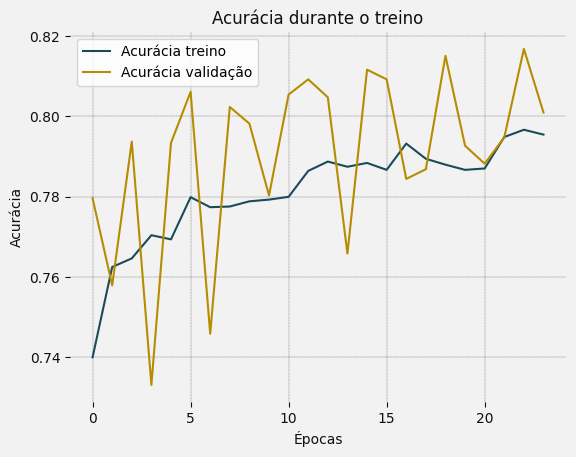

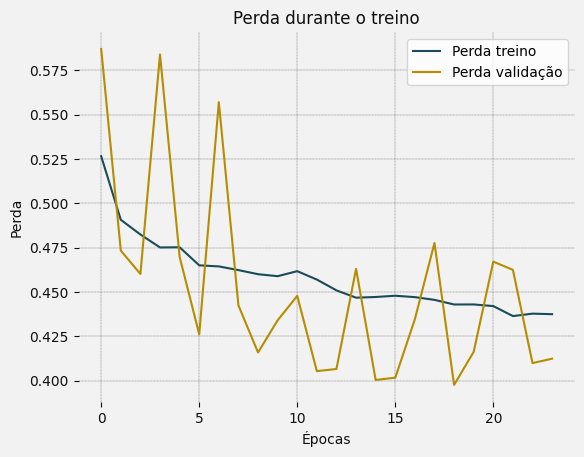

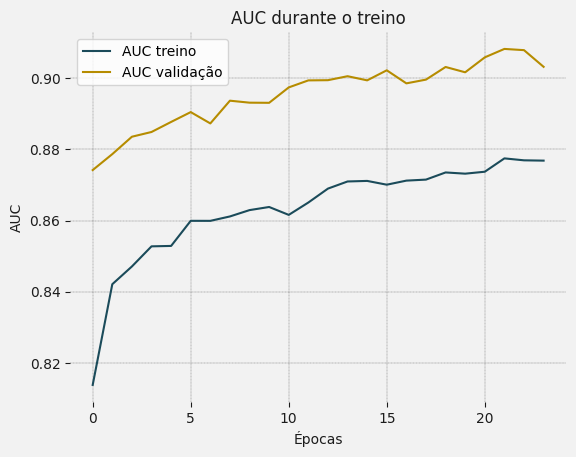

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_history(history):
    # === Accuracy ===
    fig, ax = plt.subplots()
    ax.plot(history['accuracy'], label='Acurácia treino', color='#1B4B5A')
    ax.plot(history['val_accuracy'], label='Acurácia validação', color="#B68C00")
    
    ax.set_title('Acurácia durante o treino', color="#0f0f0f")
    ax.set_xlabel('Épocas', color='#0f0f0f')
    ax.set_ylabel('Acurácia', color='#0f0f0f')
    ax.tick_params(colors='#0f0f0f')
    ax.legend()
    ax.grid(True, color='#0f0f0f', linestyle='--', linewidth=0.2)
    ax.set_facecolor('#f2f2f2')
    fig.patch.set_facecolor('#f2f2f2')
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()

    # === Loss ===
    fig, ax = plt.subplots()
    ax.plot(history['loss'], label='Perda treino', color='#1B4B5A')
    ax.plot(history['val_loss'], label='Perda validação', color='#B68C00')

    ax.set_title('Perda durante o treino', color='#0f0f0f')
    ax.set_xlabel('Épocas', color='#0f0f0f')
    ax.set_ylabel('Perda', color='#0f0f0f')
    ax.tick_params(colors='#0f0f0f')
    ax.legend()
    ax.grid(True, color='#0f0f0f', linestyle='--', linewidth=0.2)
    ax.set_facecolor('#f2f2f2')
    fig.patch.set_facecolor('#f2f2f2')
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()

    # === AUC (Opcional) ===
    if 'auc' in history and 'val_auc' in history:
        fig, ax = plt.subplots()
        ax.plot(history['auc'], label='AUC treino', color='#1B4B5A')
        ax.plot(history['val_auc'], label='AUC validação', color='#B68C00')

        ax.set_title('AUC durante o treino', color='#1c1c1c')
        ax.set_xlabel('Épocas', color='#1c1c1c')
        ax.set_ylabel('AUC', color='#1c1c1c')
        ax.tick_params(colors='#1c1c1c')
        ax.legend()
        ax.grid(True, color='#1c1c1c', linestyle='--', linewidth=0.2)
        ax.set_facecolor('#f2f2f2')
        fig.patch.set_facecolor('#f2f2f2')
        for spine in ax.spines.values():
            spine.set_visible(False)
        plt.show()

plot_history(history.history)

### 6. Fine-tuning

| Parâmetro | Descrição | Valor | Justificativa
| --- | --- | --- | --- |
| `learning_rate` | Nova taxa de aprendizado | 1e-5 | Taxa 100x menor que inicial para ajustes sutis sem "quebrar" features úteis já aprendidas |

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1356s 4s/step - accuracy: 0.7747 - auc: 0.8573 - loss: 0.4921 - val_accuracy: 0.7025 - val_auc: 0.7621 - val_loss: 0.6489
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1322s 4s/step - accuracy: 0.8332 - auc: 0.9120 - loss: 0.3797 - val_accuracy: 0.7569 - val_auc: 0.8660 - val_loss: 0.4836
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1296s 4s/step - accuracy: 0.8449 - auc: 0.9222 - loss: 0.3568 - val_accuracy: 0.8698 - val_auc: 0.9421 - val_loss: 0.3077
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1286s 4s/step - accuracy: 0.8557 - auc: 0.9306 - loss: 0.3394 - val_accuracy: 0.8698 - val_auc: 0.9463 - val_loss: 0.2984
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1286s 4s/step - accuracy: 0.8721 - auc: 0.9461 - loss: 0.2992 - val_accuracy: 0.8784 - val_auc: 0.9517 - val_loss: 0.2806
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1291s 4s/step - accuracy: 0.8716 - auc: 0.9491 - loss: 0.2905 - val_accuracy: 0.8826 - val_auc: 0.9485 - val_loss: 0.2935
Epoch 7/10
363/363 ━━━━━━━━━

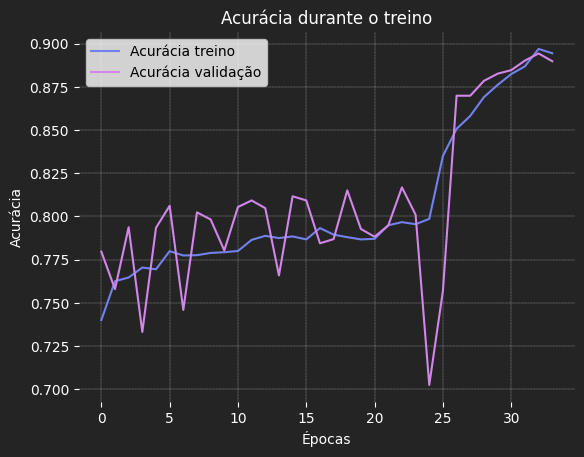

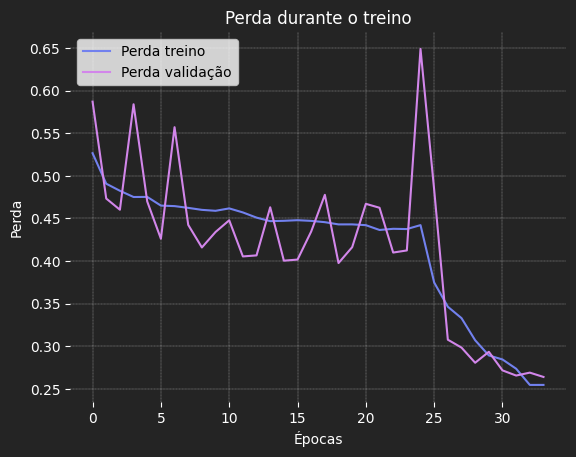

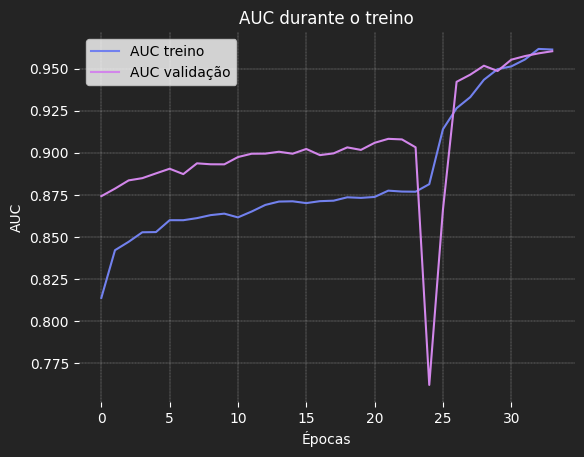

In [ ]:
model_fine_checkpoint = ModelCheckpoint(
    'best_model_fine.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True
)

# Descongela algumas camadas para fine-tuning
base_model = model.layers[1]
base_model.trainable = True

# Congela as primeiras N camadas (ajuste conforme necessário)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompila com learning rate menor
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Continua o treinamento
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, model_fine_checkpoint]
)

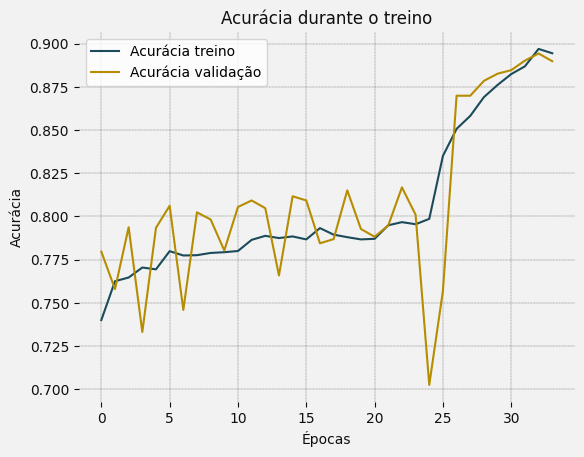

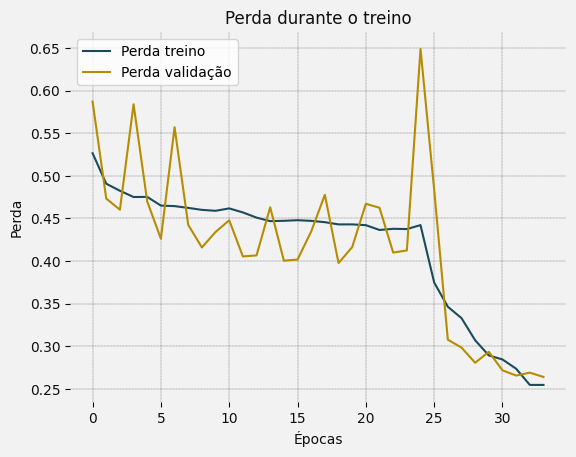

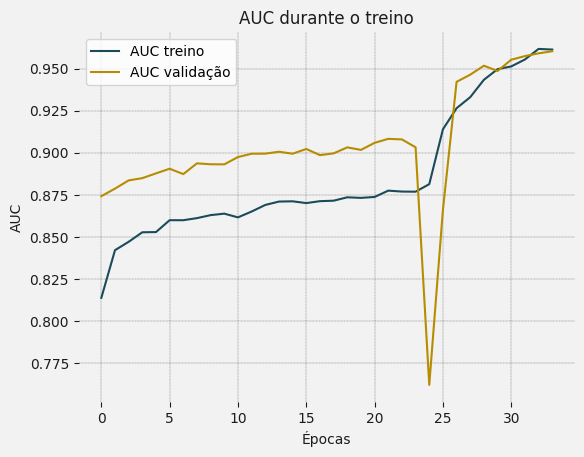

In [30]:
try:
    # Combina históricos
    combined_history = {
        k: history.history[k] + history_fine.history[k] 
        for k in history.history
    }

    plot_history(combined_history)
except:
    print(history.history.keys())
    print(history_fine.history.keys())

### 7. Salvamento

In [8]:
# Apenas para Backup
model.save('cancer_detection_model.keras')

## 8. Testes

In [13]:
def get_benign_files_names():
    path = os.path.join("..", "dataset", "Benign")
    return os.listdir(path)

def get_malignant_files_names():
    path = os.path.join("..", "dataset", "Malignant")
    return os.listdir(path)

In [21]:
def generate_random_indexes(max_index:int, quantity:int):
    return random.sample(range(1, max_index), quantity)

In [22]:
# === Função para carregar imagem ===
def load_and_preprocess_image(image_path, image_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(image_size)
    img = np.array(img) / 255.0  # Normaliza igual no treino
    img = np.expand_dims(img, axis=0)  # Adiciona batch dimension
    return img

# === Função para testar os modelos ===
def tests():
    results_dict = dict()
    
    models = ('best_model.keras', 'best_model_fine.keras')
    
    benign_files_names = get_benign_files_names()
    malignant_files_names = get_malignant_files_names()
    
    tests_quantity = 1000
    
    benign_indexes = generate_random_indexes(len(benign_files_names), tests_quantity)
    malignant_indexes  =generate_random_indexes(len(malignant_files_names), tests_quantity)
    
    for model in models:
        tf_model = tf.keras.models.load_model(model)
        results_dict[model.split('.')[0]] = dict()
        
        for i in range(0, tests_quantity):
            # === Coleta de Resultados Benignos ===
            img = load_and_preprocess_image(f'../dataset/Benign/{benign_files_names[benign_indexes[i]]}')
            results_dict[model.split('.')[0]][f'Benign/{i}.jpg'] = 1 if tf_model.predict(img)[0][0] < 0.5 else 0
            
            # === Coleta de Resultados Malignos === 
            img = load_and_preprocess_image(f'../dataset/Malignant/{malignant_files_names[malignant_indexes[i]]}')
            results_dict[model.split('.')[0]][f'Malignant/{i}.jpg'] = 1 if tf_model.predict(img)[0][0] >= 0.5 else 0
            
    return results_dict
            
df = pd.DataFrame(tests())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [23]:
# === Resultados ===
df.sum()

best_model         1577
best_model_fine    1847
dtype: int64